In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import tensorflow as tf
import tensorflow_probability as tfp
import timeit

# Solución de la ecuación de calor por diferencias finitas
La ecuación de calor en una dimensión es:
    <center> $\frac{\partial u}{\partial t}=\alpha \frac{\partial ^2 u}{\partial x^2}$,     t>0, 0 < x < L </center>
Con condición inicial:
    <center> u(x,0)=$\sin{\frac{\pi x}{L}}$, 0 < x < L </center>
Con condiciones de frontera de Dirichlet:
    <center> u(0,t)=0, u(L,t)=0, t>0  </center>
O de Neumann:
    <center> $\frac{\partial u}{\partial x}(0,t)=0$, $\frac{\partial u}{\partial x}(L,t)=0$,    t>0 </center>

# Método explicito
Solución de la ecuación de calor por el método explicito para condiciones de frontera de Dirichlet y de Neumann

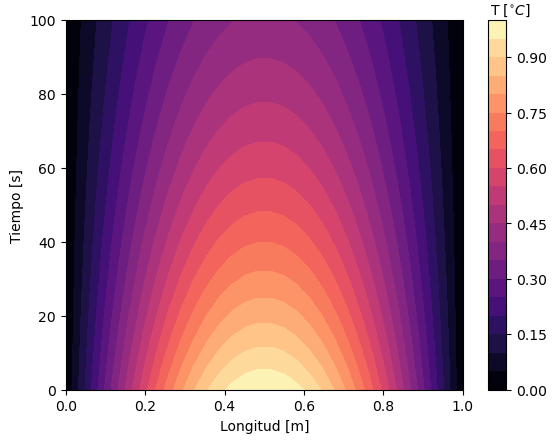

In [2]:
##### Variables globales
L = 1         # Longitud de la barra
tmax = 100     # Tiempo total
Nt = 560      # Pasos de tiempo
Nx = 32       # Pasos sobre la barra
alpha = 0.0009  # Coeficiente de difusividad termica

### Planteamiento del problema
# du/dt= alpha d^2u/dx ^2
# t>0 0<x<1

# Condicion inicial
u0= lambda x: np.sin(np.pi*x/L)

# Condiciones de frontera de Dirichlet
# u=0 en x=0
# u=0 en x=1
u_0x =0 # Primera condicion de frontera
u_Lx =0 # Segunda condicion de frontera

# Condiciones de frontera de Newmann
#u_0x = None # Primera condicion de frontera
#u_Lx = None # Segunda condicion de frontera

# Calculos de dx y dt
dx = L/(Nx-1.0)
dt = tmax/(Nt-1.0)

# Solucion de la ecuacion de calor con diferencias finitas
# hacia adelante en el tiempo y centradas en el expacio (explicito)
def euler_explicito(Nt, dx, dt, u0, L, alpha, u_0x=0, u_Lx=0):
    r=alpha*( dt / (dx **2)) # Parametro de estabilidad <= 1/2
    # Dominio espacio temporal
    X=np.arange(0,L+dx ,dx)
    t=np.arange(0, Nt*dt ,dt)
    # Vectores vacios para la solucion
    sol =np.zeros((Nt ,len(X)))
    u_n =np.zeros(len(X))
    # Se calculan las condiciones inicialse con la funcion u0
    u0=u0(X)
    # y se aplican las condiciones iniciales
    u=u0
    # Resolvemos
    for n in range(Nt):
        u_n[1: -1] = u[1: -1]+ r*(u[: -2] -2*u[1: -1]+ u[2:])
        
        # Aplicamos condiciones de frontera
        if u_0x==None:
            u[0] = u[0]+2*r*(u[1]-u[0])  # Primera condicion de frontera de Neumann
        else:
            u[0] = u_0x # Primera condicion de frontera de Dirichlet
        if u_Lx==None:
            u[-1]= u[-1]+2*r*(-u[-1]+u[-2]) # Segunda condicion de frontera de Neumann
        else:
            u[-1]= u_Lx # Segunda condicion de frontera de Dirichlet
            
            
        # Asignamos u_n a u
        u=u_n
        # Se guarda la solucion
        sol[n]=u
    return X, t, r, sol
    
x, t, r, sol = euler_explicito(Nt, dx, dt, u0, L, alpha, u_0x=0, u_Lx=0)

# Grafica
plt.figure(1)
plt.contourf (x, t, sol, 20, cmap ='magma')
plt.xlabel('Longitud [m]')
plt.ylabel('Tiempo [s]')
clb = plt.colorbar()
clb.set_label('T [$^{\circ}C$]', labelpad=-26, y=1.05, rotation=0)

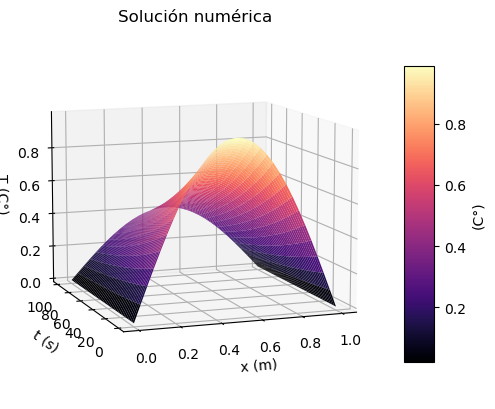

In [3]:
# Solución en 1D 
x2,t2=np.meshgrid(x,t)

fig = plt.figure(2)
ax = plt.axes(projection="3d")
ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
ax.set_zlabel('T (C°)')
plt.title('Solución numérica')
cs=ax.plot_surface(x2,t2, sol,cmap='magma')
ax.view_init(elev=10, azim=250) 
fig.colorbar(cs, shrink=0.8, aspect=10, label='(C°)') 
plt.show()

# PINN para resolver la ecuación de calor
Se resuelve el planteamiento anterior utilizando una PINN en una dimensión

In [4]:
# Parametros para el dominio espacio temporal
x_min = 0
x_max = L  # Dominio en x. Inicia en 0
t_min = 0
t_max = 100 # Tiempo total. Inicia en 0

# Se define el dominio espacio temporal
x = np.random.uniform(x_min, x_max, (1000, 1))
t = np.random.uniform(t_min, t_max, (1000, 1))
xzt = tf.convert_to_tensor(np.hstack((x, t)), dtype=tf.float32)
x = xzt[:, 0:1]
t = xzt[:, 1:2]
# Se añaden puntos para las condiciones iniciales
n_ic = 1000  

x_ic=tf.random.uniform((n_ic, 1), 0, 1)
t_ic=tf.zeros((n_ic, 1))

# Se añaden puntos en la frontera
n_boundary = 1000  

# Fronteras izquierda y derecha
x_left = tf.zeros((n_boundary, 1))
x_right = tf.ones((n_boundary, 1))

# Se combinan todos los puntos de frontera
x_boundary = tf.concat([x_left, x_right], axis=0)

# Se añade la dimensión temporal
t_boundary = tf.random.uniform((2*n_boundary, 1), t_min, t_max)

# Combine with your original random points
x = tf.concat([x, x_boundary, x_ic], axis=0)
t = tf.concat([t, t_boundary, t_ic], axis=0)

xt = tf.concat([x, t], axis=1)

def f(x):
    # Condición inicial
    return tf.sin(np.pi*x/L)

In [11]:
# Se define una red de [2]+[20]*2+[1]
# Con función de activación tanh 
# El inicializador por defecto es Glorot uniform para los pesos y Zero para los sesgos usando tf.keras.layers.Dense
# Para u(x,t)
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(1, activation=None)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x) # Esto es el output u
    

# Se define la función de pérdida de la EDP
def heat_equation_residual(model_u, xt):
    x = xt[:, 0:1]
    t = xt[:, 1:2]
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            u = model_u(tf.concat([x, t], axis=1))
        u_t = tape1.gradient(u, t)
        u_x = tape1.gradient(u, x)
    u_xx = tape2.gradient(u_x, x)
    
    # Ecuación de calor: u_t = alpha*u_xx
    heat_residual = alpha*u_xx - u_t
    
    # Se define Loss PDE (el término de la ecuación de onda en la función de pérdida)
    loss_pde = tf.reduce_mean(tf.square(heat_residual))
    
    return loss_pde

# Se define la función de pérdida de las condiciones iniciales
def IC_residual(model_u, xt):
    x = xt[:, 0:1]
    t = xt[:, 1:2]
    u_x_0 = model_u(tf.concat([x, tf.zeros_like(t)], axis=1))
    
    # Condición inicial
    ic_loss_1 = tf.reduce_mean(tf.square(u_x_0 - f(x)))
    
    return ic_loss_1

# Se define la función de pérdida de las condiciones de frontera
def BC_residual(model_u, xt):
    x = xt[:, 0:1]
    t = xt[:, 1:2]
    
    u = model_u(tf.concat([x, t], axis=1))
    
    # Condiciones de Dirichlet iguales a cero
    #Frontera izquierda
    mask_left = tf.abs(x) < 1e-5
    bc_loss_left = tf.reduce_mean(tf.where(mask_left, tf.square(u), 0.0))
    #Frontera derecha
    mask_right = tf.abs(x - 1) < 1e-5
    bc_loss_right = tf.reduce_mean(tf.where(mask_right, tf.square(u), 0.0))
    
    return bc_loss_left + bc_loss_right


# Función de pérdida
def loss_fn(model_u, xt):
    # Loss EDP
    loss_pde = heat_equation_residual(model_u, xt)
    
    # Loss condición inicial
    loss_ic = IC_residual(model_u, xt)
    
    # Loss condición de frontera 
    loss_bc = BC_residual(model_u, xt) 
    
    # Total loss
    # Pesos de cada término en la función de pérdida
    lambda_pde = 1.0 ##0.1 # 0.03
    lambda_bc = 0.1 #0.1 # 0.0005
    lambda_ic = 2.0 # 2 # 1
    
    total_loss = lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic
    return total_loss


# Optimizadores: Adam + L-BFGS-B
adam = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
lbfgs = tfp.optimizer.lbfgs_minimize  # TensorFlow Probability L-BFGS-B

# Entrenamiento con ADAM
@tf.function
def train_step(model_u, xt):
    with tf.GradientTape(persistent=True) as tape:
        loss = loss_fn(model_u, xt)
    gradients_u = tape.gradient(loss, model_u.trainable_variables)
    adam.apply_gradients(zip(gradients_u, model_u.trainable_variables))
    
    # Manualmente borramos el tape para salvar memoria
    del tape
    return loss


# Example training loop
def train(model_u, xt, epochs=1000):
    Total_loss=[]
    Loss_PDE=[]
    Ic_loss=[]
    Bc_loss=[]
    # Entrenamiento con adam
    start = timeit.default_timer()
    for epoch in range(epochs):
        loss = train_step(model_u, xt)
        Total_loss.append(loss.numpy())
        
        # Loss EDP
        loss_pde = heat_equation_residual(model_u, xt)
        Loss_PDE.append(loss_pde.numpy())
    
        # Loss condición inicial
        loss_ic = IC_residual(model_u, xt)
        Ic_loss.append(loss_ic.numpy())
    
        # Loss condición de frontera (free surface: Neumann boundary)
        loss_bc = BC_residual(model_u, xt)  # Neumann boundary condition
        Bc_loss.append(loss_bc.numpy())
            
        if epoch % 1000 == 0:
            stop = timeit.default_timer()
            print('Time: ', stop - start)
            print(f'Epoch {epoch}, Loss: {loss.numpy()}, PDE Loss: {loss_pde.numpy()}, Initial Cond. Loss: {loss_ic.numpy()}, Boundary Loss: {loss_bc.numpy()}')
            start = timeit.default_timer()
            
    # L-BFGS refinamiento
    #print("Starting L-BFGS optimization")
    #train_lbfgs(model_u, xt)
    
    # Compute final losses
    final_loss = loss_fn(model_u, xt)
    final_loss_pde = heat_equation_residual(model_u, xt)
    final_loss_ic = IC_residual(model_u, xt)
    final_loss_bc = BC_residual(model_u, xt)
    
    print(f'Final Loss: {final_loss.numpy()}, PDE Loss: {final_loss_pde.numpy()}, Initial Cond. Loss: {final_loss_ic.numpy()}, Boundary Loss: {final_loss_bc.numpy()}')
    
    return Loss_PDE, Ic_loss, Bc_loss, Total_loss

In [12]:
# Create instances of the models
model_u = PINN()
Loss_PDE, Ic_loss, Bc_loss, Total_loss=train(model_u, xt, epochs=10000)

Time:  1.4857630999999856
Epoch 0, Loss: 0.6133876442909241, PDE Loss: 0.017383109778165817, Initial Cond. Loss: 0.2917827367782593, Boundary Loss: 0.08277851343154907
Time:  34.81443709999985
Epoch 1000, Loss: 0.2903381586074829, PDE Loss: 0.0004547585267573595, Initial Cond. Loss: 0.1448216438293457, Boundary Loss: 0.0022435705177485943
Time:  35.6301325000004
Epoch 2000, Loss: 0.24717865884304047, PDE Loss: 0.002173178130760789, Initial Cond. Loss: 0.12239967286586761, Boundary Loss: 0.0011614280520007014
Time:  34.33618320000005
Epoch 3000, Loss: 0.07131422311067581, PDE Loss: 0.0008438063669018447, Initial Cond. Loss: 0.034855302423238754, Boundary Loss: 0.005867530591785908
Time:  35.356388100000004
Epoch 4000, Loss: 0.0049726031720638275, PDE Loss: 0.0011078863171860576, Initial Cond. Loss: 0.0018109637312591076, Boundary Loss: 0.002356416080147028
Time:  35.18212259999973
Epoch 5000, Loss: 0.002832170110195875, PDE Loss: 0.0006245398544706404, Initial Cond. Loss: 0.001058421446

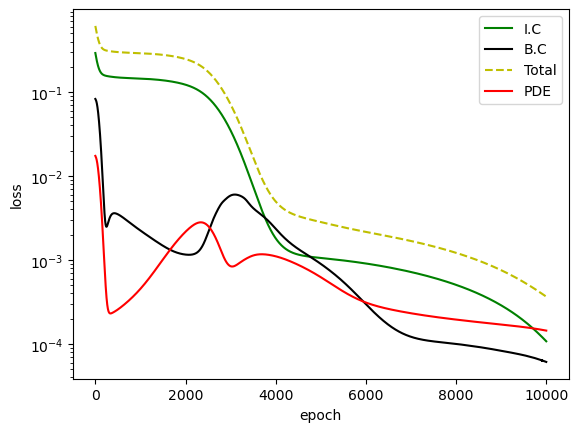

In [13]:
fig = plt.figure()
plt.plot(Ic_loss,'g',label='I.C')
plt.plot(Bc_loss,'black',label='B.C')
plt.plot(Total_loss,'--y',label='Total')
plt.plot(Loss_PDE,'r',label='PDE')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss function.png',dpi=400)
plt.show()

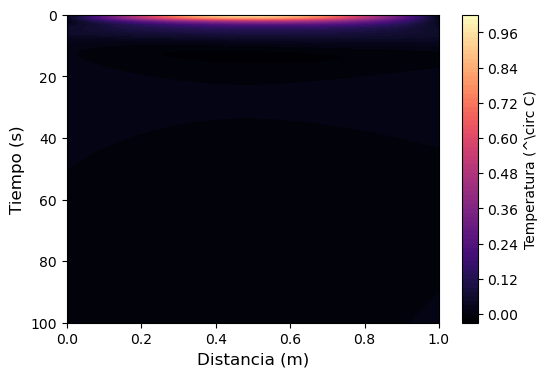

In [15]:
## Grafica
x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 100, 100)

X, T = np.meshgrid(x_test, t_test)
xt_test = tf.convert_to_tensor(np.hstack((X.reshape(-1, 1), T.reshape(-1, 1))), dtype=tf.float32)
u_pred = model_u(xt_test).numpy().reshape(100, 100)

fig5 = plt.figure(1, figsize=(6, 4))
ax = fig5.subplots()
cs = ax.contourf(X, T, u_pred, levels=100, cmap='magma')
ax.invert_yaxis()
ax.set_xlabel(r'Distancia (m)', fontsize=12)
ax.set_ylabel(r'Tiempo (s)', fontsize=12)
#ax.set_aspect('equal', adjustable='box')
fig5.colorbar(cs,label='Temperatura (^\circ C)')
plt.savefig("Heat field")
plt.show()